# Load and preprocess images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import datasets, layers, models, losses, Model, Sequential, Input
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input as preprocess_effB7
import h5py

In [2]:
print(tf.__version__)

2.10.0


In [3]:
data_dir = r'C:/Users/gaelp/Documents/watch_app/movement_database/'

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 16
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  #shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 716 files belonging to 17 classes.
Using 573 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 716 files belonging to 17 classes.
Using 143 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Angelus 210', 'Angelus 215', 'Buren 1281', 'Excelsior 4X', 'Hanhart 40', 'Landeron 148', 'Landeron 248', 'Landeron 39', 'Landeron 48 54', 'Mido 1300', 'Pierce 134', 'Urofa 59', 'Valjoux 22', 'Valjoux 7730', 'Valjoux 92', 'Venus 170', 'Venus 175']


### Visualize the data

Here are the first nine images from the training dataset.

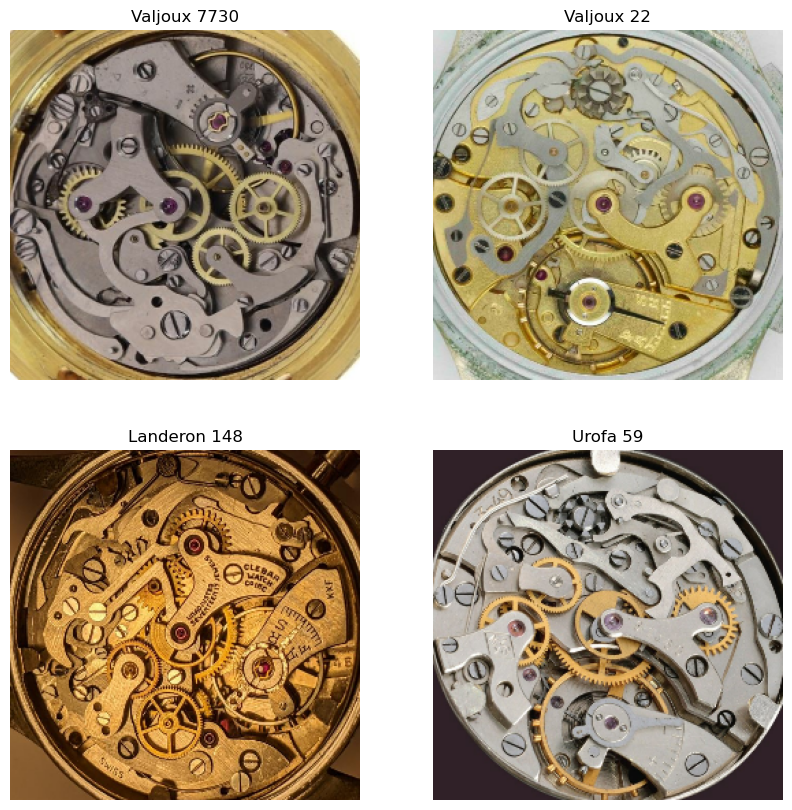

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

### Data augmentation layer

In [13]:
img_augmentation = tf.keras.Sequential([layers.RandomRotation(0.25)])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [14]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB7(include_top=False, 
                           input_tensor=x, 
                           #weights="imagenet"
                           )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )
    return model

In [15]:
with tf.device("/cpu:0"):
    model = build_model(num_classes)
#model.summary()

In [16]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds,
                        validation_data=val_ds, 
                        epochs=40)

Epoch 1/40
36/36 [==============================] - 157s 4s/step - loss: 3.4787 - accuracy: 0.0803 - val_loss: 2.7065 - val_accuracy: 0.1888
Epoch 2/40
36/36 [==============================] - 146s 4s/step - loss: 2.9244 - accuracy: 0.1640 - val_loss: 2.6017 - val_accuracy: 0.3007
Epoch 3/40
36/36 [==============================] - 141s 4s/step - loss: 2.5299 - accuracy: 0.2373 - val_loss: 2.4842 - val_accuracy: 0.3776
Epoch 4/40
36/36 [==============================] - 141s 4s/step - loss: 2.2716 - accuracy: 0.3072 - val_loss: 2.3496 - val_accuracy: 0.4266
Epoch 5/40
36/36 [==============================] - 142s 4s/step - loss: 2.1142 - accuracy: 0.3525 - val_loss: 2.2057 - val_accuracy: 0.4825
Epoch 6/40
36/36 [==============================] - 141s 4s/step - loss: 1.9133 - accuracy: 0.4014 - val_loss: 2.0578 - val_accuracy: 0.5035
Epoch 7/40
36/36 [==============================] - 141s 4s/step - loss: 1.8034 - accuracy: 0.4398 - val_loss: 1.9103 - val_accuracy: 0.5315
Epoch 8/40
36

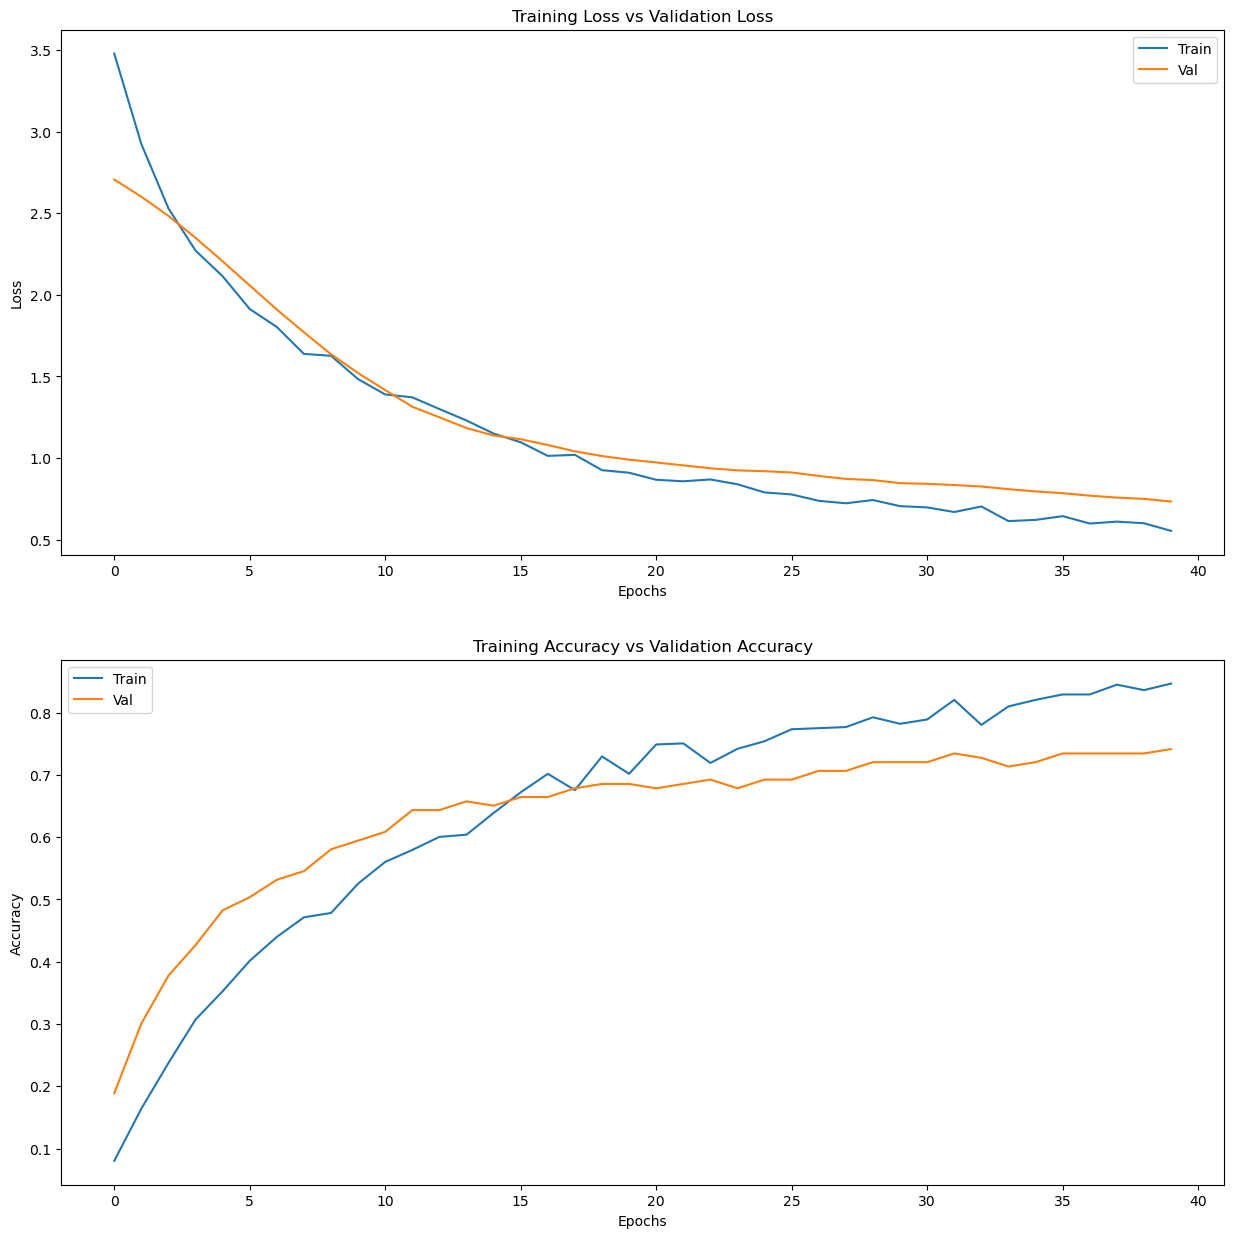

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

In [18]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )


unfreeze_model(model)

In [19]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds,
                        validation_data=val_ds, 
                        epochs=10)

Epoch 1/10
36/36 [==============================] - 155s 4s/step - loss: 0.5565 - accuracy: 0.8307 - val_loss: 0.7243 - val_accuracy: 0.7413
Epoch 2/10
36/36 [==============================] - 140s 4s/step - loss: 0.5331 - accuracy: 0.8464 - val_loss: 0.7099 - val_accuracy: 0.7273
Epoch 3/10
36/36 [==============================] - 138s 4s/step - loss: 0.5122 - accuracy: 0.8621 - val_loss: 0.7068 - val_accuracy: 0.7413
Epoch 4/10
36/36 [==============================] - 137s 4s/step - loss: 0.4826 - accuracy: 0.8743 - val_loss: 0.6954 - val_accuracy: 0.7413
Epoch 5/10
36/36 [==============================] - 214s 6s/step - loss: 0.5027 - accuracy: 0.8621 - val_loss: 0.6834 - val_accuracy: 0.7552
Epoch 6/10
36/36 [==============================] - 150s 4s/step - loss: 0.4538 - accuracy: 0.8761 - val_loss: 0.6619 - val_accuracy: 0.7483
Epoch 7/10
36/36 [==============================] - 151s 4s/step - loss: 0.4678 - accuracy: 0.8604 - val_loss: 0.6592 - val_accuracy: 0.7622
Epoch 8/10
36

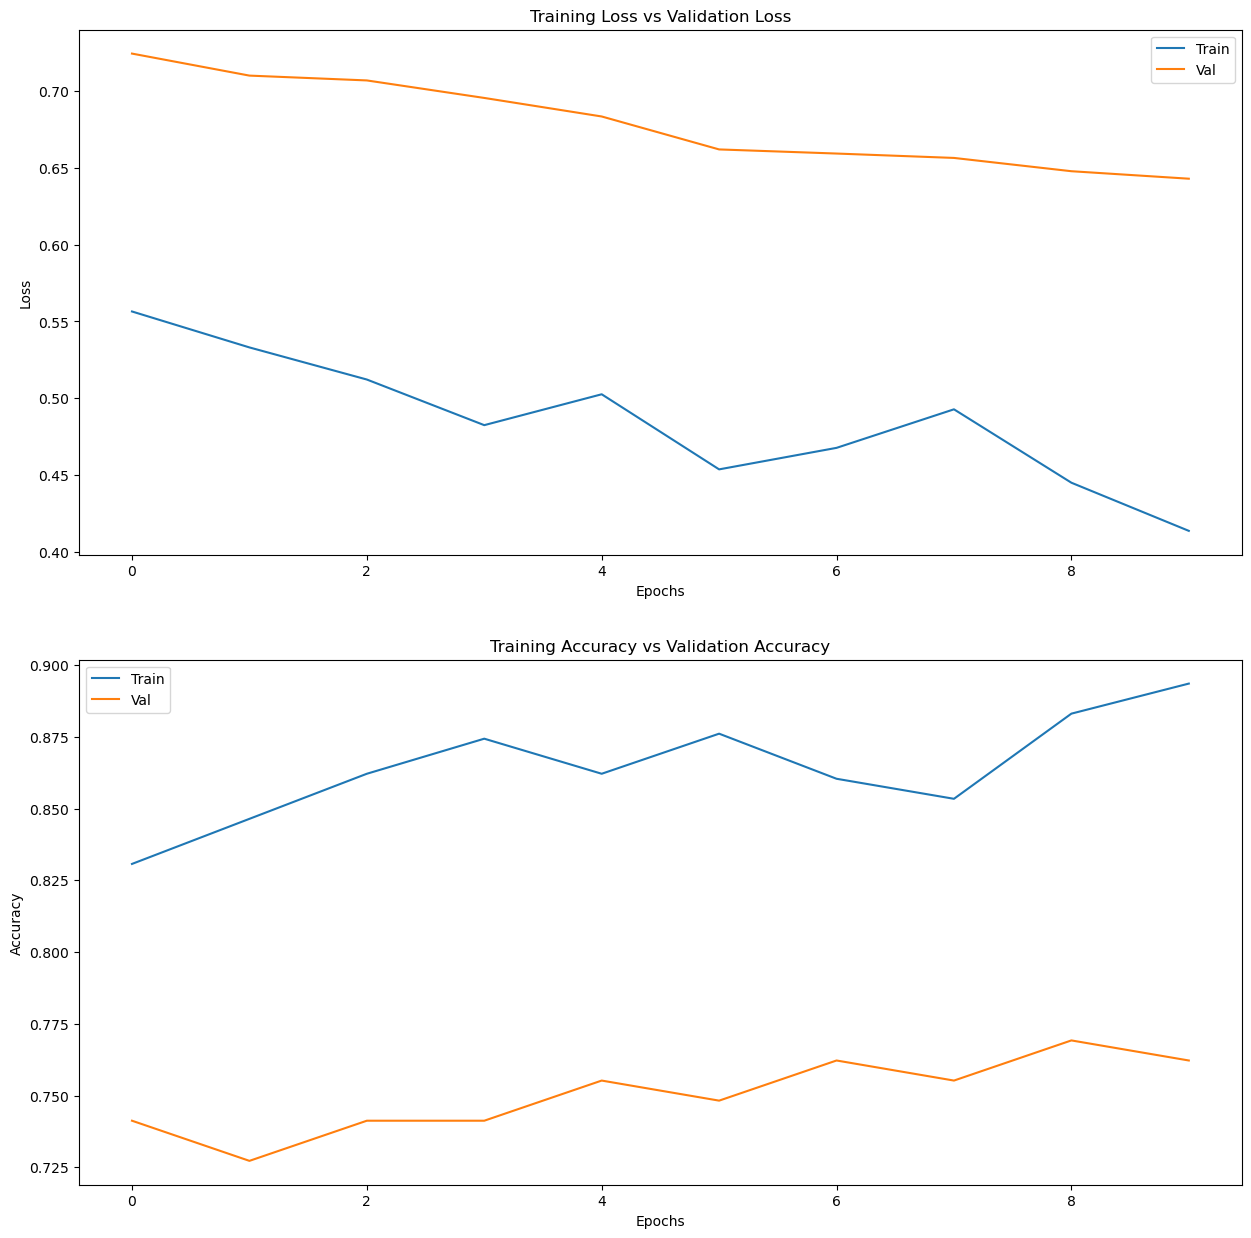

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [21]:
model.save('/models/model_EfficientNetB7_24022023')

INFO:tensorflow:Assets written to: /models/model_EfficientNetB7_24022023\assets


INFO:tensorflow:Assets written to: /models/model_EfficientNetB7_24022023\assets


In [22]:
def get_img_array(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [31]:
img_path = 'test_image_2.jpg'
test_img = get_img_array(img_path, (256, 256, 3))

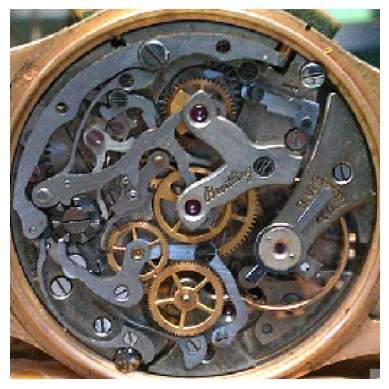

In [32]:
plt.axis('off')
plt.imshow(test_img[0].astype('uint8'))
plt.show()

In [33]:
with tf.device("/cpu:0"):
    preds = model.predict(test_img)
    print("Predicted:", class_names[np.argmax(preds)])

1/1 [==============================] - 0s 344ms/step
Predicted: Venus 175
